In [1]:
import sys
print (sys.version)

import sys
print (sys.version)

# ! pip3 install fastai==0.7.0
# ! pip3 install torchtext==0.2.3

# ! pip3 install torch
# ! pip3 install torchvision

%matplotlib inline
%reload_ext autoreload
%autoreload 2

# from fastai.conv_learner import *
# from fastai.dataset import *

import torch
import torch.nn as nn
from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
import torch.optim as optim
import time, copy
torch.cuda.set_device(0)

!mkdir data
!wget http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar -P data/
!wget https://storage.googleapis.com/coco-dataset/external/PASCAL_VOC.zip -P data/
!tar -xf data/VOCtrainval_06-Nov-2007.tar -C data/
!unzip data/PASCAL_VOC.zip -d data/
!rm -rf data/PASCAL_VOC.zip data/VOCtrainval_06-Nov-2007.tar

3.5.2 (default, Nov 12 2018, 13:43:14) 
[GCC 5.4.0 20160609]
3.5.2 (default, Nov 12 2018, 13:43:14) 
[GCC 5.4.0 20160609]
mkdir: cannot create directory ‘data’: File exists
URL transformed to HTTPS due to an HSTS policy
--2019-03-19 22:12:58--  https://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
Resolving pjreddie.com (pjreddie.com)... 128.208.3.39
Connecting to pjreddie.com (pjreddie.com)|128.208.3.39|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460032000 (439M) [application/octet-stream]
Saving to: 'data/VOCtrainval_06-Nov-2007.tar.1’

VOCtrainval_06-Nov- 100%[===================>] 438.72M  17.2MB/s    in 31s     

2019-03-19 22:13:31 (14.0 MB/s) - 'data/VOCtrainval_06-Nov-2007.tar.1’ saved [460032000/460032000]

--2019-03-19 22:13:31--  https://storage.googleapis.com/coco-dataset/external/PASCAL_VOC.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 216.58.196.144, 2404:6800:4006:805::2010
Connecting to storage.googleapis.com (stor

In [2]:
import collections
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(1971)

In [3]:
PATH = Path('data/PASCAL_VOC/')
list(PATH.iterdir())

[PosixPath('data/PASCAL_VOC/pascal_train2007.json'),
 PosixPath('data/PASCAL_VOC/pascal_val2007.json'),
 PosixPath('data/PASCAL_VOC/pascal_test2007.json'),
 PosixPath('data/PASCAL_VOC/pascal_train2012.json'),
 PosixPath('data/PASCAL_VOC/pascal_val2012.json')]

In [4]:
train_json = json.load((PATH/'pascal_train2007.json').open())

In [5]:
train_json.keys()

dict_keys(['annotations', 'categories', 'type', 'images'])

In [6]:
IMAGES, TYPE, ANNOTATIONS, CATEGORIES = ['images', 'type', 'annotations', 'categories']

In [7]:
images_dir = Path('./data/VOCdevkit/VOC2007/JPEGImages/')
next(images_dir.iterdir())

PosixPath('data/VOCdevkit/VOC2007/JPEGImages/003508.jpg')

In [8]:
# dictionary to keep image_id vs bbox and and corresponding category
annotation_dict = collections.defaultdict(lambda:[])
for item in train_json[ANNOTATIONS]:
#     print (item['image_id'])
#     print (item['bbox'])
#     print (item['category_id'])
    annotation_dict[item['image_id']].append((item['category_id'], item['bbox']))
#     break

In [9]:
len(annotation_dict)

2501

In [10]:
# dictionary to keep image id to image path
image_id_to_filename = dict()
for item in train_json[IMAGES]:
    image_id_to_filename[item['id']]= images_dir/item['file_name']

In [36]:
image_id_to_category = dict()
for item in train_json[CATEGORIES]:
    image_id_to_category[item['id']]=item['name']
    
id_to_WH = dict()
for item in train_json[IMAGES]:
    print (item)
    id_to_WH[item['id']]={'height':item['height'], 'width':item['width']}

{'file_name': '000012.jpg', 'height': 333, 'id': 12, 'width': 500}
{'file_name': '000017.jpg', 'height': 364, 'id': 17, 'width': 480}
{'file_name': '000023.jpg', 'height': 500, 'id': 23, 'width': 334}
{'file_name': '000026.jpg', 'height': 333, 'id': 26, 'width': 500}
{'file_name': '000032.jpg', 'height': 281, 'id': 32, 'width': 500}
{'file_name': '000033.jpg', 'height': 366, 'id': 33, 'width': 500}
{'file_name': '000034.jpg', 'height': 500, 'id': 34, 'width': 360}
{'file_name': '000035.jpg', 'height': 375, 'id': 35, 'width': 500}
{'file_name': '000036.jpg', 'height': 500, 'id': 36, 'width': 332}
{'file_name': '000042.jpg', 'height': 335, 'id': 42, 'width': 500}
{'file_name': '000044.jpg', 'height': 333, 'id': 44, 'width': 500}
{'file_name': '000047.jpg', 'height': 333, 'id': 47, 'width': 500}
{'file_name': '000048.jpg', 'height': 500, 'id': 48, 'width': 375}
{'file_name': '000061.jpg', 'height': 333, 'id': 61, 'width': 500}
{'file_name': '000064.jpg', 'height': 500, 'id': 64, 'width': 

In [12]:
# image_id_to_filename

In [13]:
def coord_to_hw(bb):
    return np.array([bb[0], bb[1], bb[2]-bb[0]+1, bb[3]-bb[1]+1])

def hw_to_coord(bb, image_id=None, normalize=None):
    if normalize == True and image_id is not None:
        xmin = bb[0]/id_to_WH[image_id]['width']
        ymin = bb[1]/id_to_WH[image_id]['height']
        xmax = (bb[0]+bb[2])/id_to_WH[image_id]['width']
        ymax = (bb[1]+bb[3])/id_to_WH[image_id]['height']
        return np.array([xmin, ymin, xmax, ymax])
    else:
        return np.array([bb[0], bb[1], bb[0]+bb[2], bb[1]+bb[3]])

def draw_image(image, figsize=None, ax=None):
    if ax is None: 
        fig, ax = plt.subplots()
    ax.imshow(image)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def draw_bbox(ax, bbox):
    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], fill=False, edgecolor='white', linewidth=2)
    ax.add_patch(rect)
    
def add_text(ax, bb, txt):
    text = ax.text(bb[0], bb[1], txt, fontsize=14, color='white', weight='bold', backgroundcolor='black') 
    
def read_image(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

from sklearn.preprocessing import LabelEncoder

class CategoryUtil:
    def __init__(self, labels):
        self.labels = np.unique(labels)
        self.encode_dict = dict()
        self.decode_dict = dict()
        for id, label in enumerate(self.labels):
            self.encode_dict[label] = id
            self.decode_dict[id] = label
            
    def encode(self, label):
        return self.encode_dict[label]
    
    def decode(self, id):
        return self.decode_dict[id]

(15, [184, 61, 95, 138])
(13, [89, 77, 314, 259])


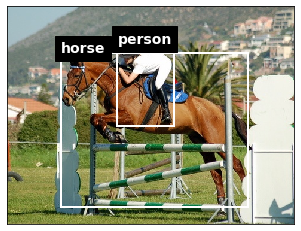

In [14]:
image_id = 17
image = read_image(str(image_id_to_filename[image_id]))
ax = draw_image(image)
for bbox in annotation_dict[image_id]:
    print (bbox)
    draw_bbox(ax, bbox[1])
    add_text(ax, bbox[1], image_id_to_category[bbox[0]])

In [15]:
annotation_dict_large = dict()
for image_id in annotation_dict:
    bboxes = (annotation_dict[image_id])
    lrg_bb = sorted(bboxes, key=lambda x: x[1][2]*x[1][3], reverse=True)[0]    
    annotation_dict_large[image_id]=lrg_bb

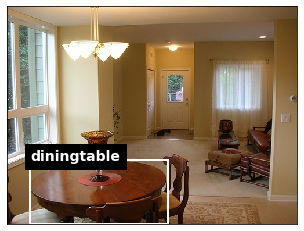

In [16]:
image_id = 235
image = read_image(str(image_id_to_filename[image_id]))
ax = draw_image(image)
draw_bbox(ax, annotation_dict_large[image_id][1])
add_text(ax, annotation_dict_large[image_id][1], image_id_to_category[annotation_dict_large[image_id][0]])

In [17]:
df = pd.DataFrame(
{
    'image_path': [image_id_to_filename[id] for id in annotation_dict_large],
    'category': [image_id_to_category[annotation_dict_large[id][0]] for id in annotation_dict_large],
    'bbox': [','.join(list(map(str, hw_to_coord(
        annotation_dict_large[id][1], id, normalize=True)))) for id in annotation_dict_large]
})


df.head()

,bbox,category,image_path
0,"0.634,0.48348348348348347,0.934,0.858858858858...",tvmonitor,data/VOCdevkit/VOC2007/JPEGImages/004100.jpg
1,"0.9,0.5552238805970149,0.994,0.6776119402985075",car,data/VOCdevkit/VOC2007/JPEGImages/008197.jpg
2,"0.726,0.224,0.998,1.0",person,data/VOCdevkit/VOC2007/JPEGImages/008199.jpg
3,"0.38,0.7466666666666667,0.848,1.0",chair,data/VOCdevkit/VOC2007/JPEGImages/004106.jpg
4,"0.074,0.49866666666666665,0.608,0.96",sofa,data/VOCdevkit/VOC2007/JPEGImages/008203.jpg


In [18]:
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from glob import glob
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

input_size = 224
data_transforms = {
    'train': transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

class MyCustomDataset(Dataset):
    def __init__(self, df, phase):
        self.df = df
        self.transforms = data_transforms[phase]              
        
    def __getitem__(self, index):
        image = read_image(str(self.df.iloc[index]['image_path']))
        image = self.transforms(image)        
        label = catutil.encode(self.df.iloc[index]['category'])
        bbox = self.df.iloc[index]['bbox']
        bbox = torch.tensor(list(map(float, bbox.split(','))))
        return image, label, bbox

    def __len__(self):
        return self.df.shape[0]


df = df.sample(frac=1)

n_train = int(df.shape[0]*80/100)
n_val = df.shape[0] - n_train
df_train = df.head(n_train)
df_val = df.tail(n_val)

catutil = CategoryUtil(df.category)

dataset = MyCustomDataset(df_train, 'train')
train_data_loader = DataLoader(dataset, batch_size=16, shuffle=True)

dataset = MyCustomDataset(df_val, 'val')
val_data_loader = DataLoader(dataset, batch_size=16, shuffle=False)

dataloaders_dict = {
    'train': train_data_loader,
    'val': val_data_loader
}

In [19]:
df.head()

,bbox,category,image_path
1244,"0.152,0.78,0.784,0.97",bus,data/VOCdevkit/VOC2007/JPEGImages/005961.jpg
2337,"0.008,0.006006006006006006,0.862,1.0",person,data/VOCdevkit/VOC2007/JPEGImages/003817.jpg
342,"0.028,0.30666666666666664,0.532,0.642666666666...",boat,data/VOCdevkit/VOC2007/JPEGImages/008725.jpg
2012,"0.26,0.2906666666666667,0.716,1.0",bird,data/VOCdevkit/VOC2007/JPEGImages/008051.jpg
977,"0.218,0.16,0.922,0.7173333333333334",cat,data/VOCdevkit/VOC2007/JPEGImages/001486.jpg


In [20]:
# for data in data_loader:
#     print (data[0])
#     break

In [21]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels, bboxes in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                bboxes = bboxes.to(device).to(dtype=torch.float)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, bboxes)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                

            epoch_loss = running_loss / len(dataloaders[phase].dataset)


            print('{} Loss: {:.4f}'.format(phase, epoch_loss))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_loss_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_loss_history

In [22]:
import torchvision as tv

In [23]:
model_ft = tv.models.resnet101(pretrained=True)
set_parameter_requires_grad(model_ft, feature_extracting=True)
num_ftrs = model_ft.fc.in_features



# 4 output , xmin, ymin, xmax, ymax
num_classes = 4 
model_ft.fc = nn.Linear(num_ftrs, num_classes)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /home/guest/.torch/models/resnet101-5d3b4d8f.pth
100%|██████████| 178728960/178728960 [00:16<00:00, 10637439.78it/s]


In [24]:
# model_ft

In [25]:
data_transforms['train']

Compose(
    ToPILImage()
    RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [26]:
len(np.unique(df.category.values))

20

In [27]:
# torch.cuda.get_device_name(1)

In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print (device)

cuda:0


In [29]:
model_ft = model_ft.to(device)

In [30]:
params_to_update = []
for name, param in model_ft.named_parameters():
    if param.requires_grad:
        params_to_update.append(param)

In [31]:
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

In [32]:
criterion = nn.MSELoss()
num_epochs=64

In [33]:
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=False)
torch.save(model_ft.state_dict(),'./model_ft.pth')

Epoch 0/63
----------
train Loss: 0.0909
val Loss: 0.0519

Epoch 1/63
----------
train Loss: 0.0397
val Loss: 0.0498

Epoch 2/63
----------
train Loss: 0.0388
val Loss: 0.0415

Epoch 3/63
----------
train Loss: 0.0354
val Loss: 0.0350

Epoch 4/63
----------
train Loss: 0.0345
val Loss: 0.0341

Epoch 5/63
----------
train Loss: 0.0343
val Loss: 0.0334

Epoch 6/63
----------
train Loss: 0.0341
val Loss: 0.0318

Epoch 7/63
----------
train Loss: 0.0332
val Loss: 0.0328

Epoch 8/63
----------
train Loss: 0.0324
val Loss: 0.0341

Epoch 9/63
----------
train Loss: 0.0327
val Loss: 0.0303

Epoch 10/63
----------
train Loss: 0.0307
val Loss: 0.0314

Epoch 11/63
----------
train Loss: 0.0307
val Loss: 0.0337

Epoch 12/63
----------
train Loss: 0.0307
val Loss: 0.0383

Epoch 13/63
----------
train Loss: 0.0305
val Loss: 0.0313

Epoch 14/63
----------
train Loss: 0.0301
val Loss: 0.0322

Epoch 15/63
----------
train Loss: 0.0304
val Loss: 0.0386

Epoch 16/63
----------
train Loss: 0.0311
val Loss

In [34]:
#==============

def denormalize(image, _mean=None, _std=None):
    if _mean is None and _std is None:
        _mean = [0.485, 0.456, 0.406]
        _std = [0.229, 0.224, 0.225]
    for i in range(3):
        image[:, i, :, :] = image[:, i, :, :] * _std[i] + _mean[i]
    return image

[tensor(2.6880, device='cuda:0') tensor(92.5867, device='cuda:0')
 tensor(42.6640, device='cuda:0') tensor(119.2720, device='cuda:0')]
[tensor(112.8960, device='cuda:0') tensor(117.8623, device='cuda:0')
 tensor(66.8560, device='cuda:0') tensor(71.9642, device='cuda:0')]
[tensor(59.5840, device='cuda:0') tensor(78.2507, device='cuda:0')
 tensor(64.1680, device='cuda:0') tensor(124.0507, device='cuda:0')]
[tensor(204.7360, device='cuda:0') tensor(198.3147, device='cuda:0')
 tensor(17.5760, device='cuda:0') tensor(13.5440, device='cuda:0')]
[tensor(46.1440, device='cuda:0') tensor(61.3808, device='cuda:0')
 tensor(122.8560, device='cuda:0') tensor(85.4982, device='cuda:0')]
[tensor(78.8480, device='cuda:0') tensor(100.3520, device='cuda:0')
 tensor(55.6560, device='cuda:0') tensor(73.2773, device='cuda:0')]
[tensor(28.0747, device='cuda:0') tensor(6.2720, device='cuda:0')
 tensor(150.3333, device='cuda:0') tensor(218.7280, device='cuda:0')]
[tensor(101.6960, device='cuda:0') tensor(81.83

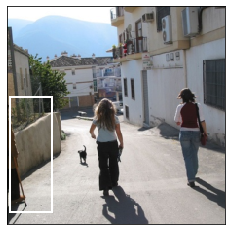

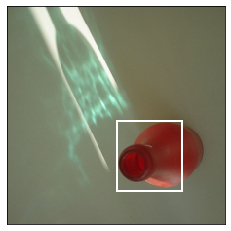

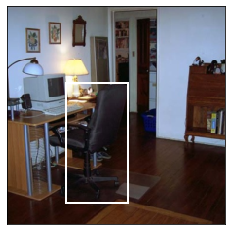

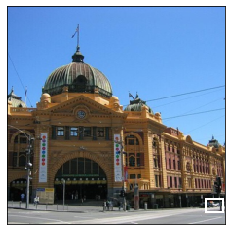

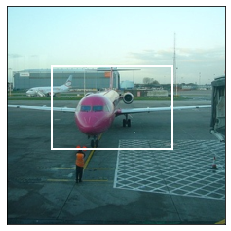

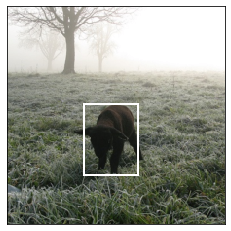

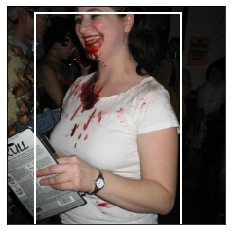

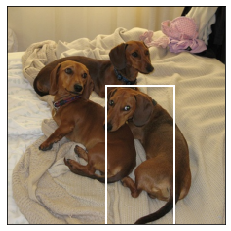

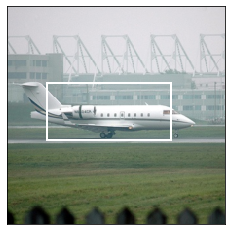

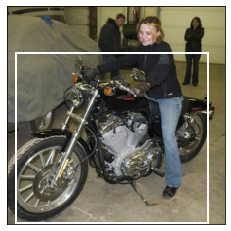

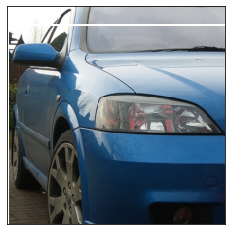

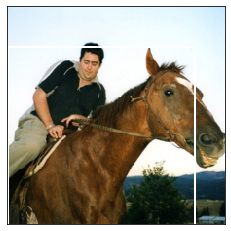

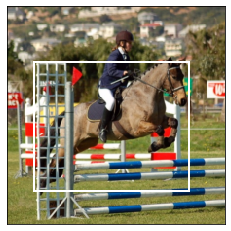

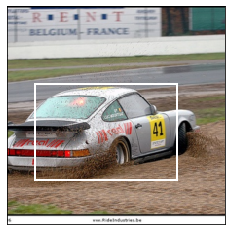

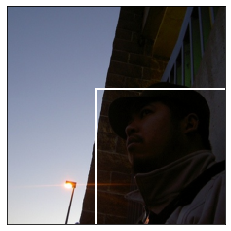

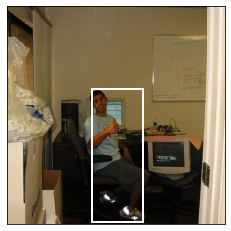

In [38]:
to_pil = transforms.ToPILImage()
for inputs, labels, bboxes in val_data_loader:
    inputs, bboxes = inputs.cuda(), bboxes.cuda()
    predictions = model_ft(inputs)
    inputs = denormalize(inputs)
    predictions = predictions.cpu().data.numpy().astype(int)
    for inp, bbox in zip(inputs, bboxes):
        ax = draw_image(to_pil(inp.cpu()))
        bbox[0], bbox[2] = bbox[0] * 224.0, bbox[2] *224.0
        bbox[1], bbox[3] = bbox[1] * 224.0, bbox[3] * 224.0
        bbox = coord_to_hw(bbox)
        draw_bbox(ax, bbox)
    break